# Problem 19: Application of a Groundwater Flow Model to a Water Supply Problem

In [1]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

In [16]:
#Store the values of each parameter into separate variables
inh = 0.0 #initial head
hk = 10.0 #hydraulic conductivity
s = 0.1 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -.963 #pumping rate ft^3/s (432 gpm)
perlen = 36 #stress period length (currently hours/change to days)
nstp = 10 #number of time steps
tsmult = 1.414 #time step multiplier
sip_it_par = 5 #SIP iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
top = 0
botm = -1
nper = 1
laytyp = 1
ipakcb = 50

#grid 44 rows, 55 cols, 1 layer
nlay = 1 #number of layers
nrow = 44 #number of rows
ncol = 55 #number of columns

#pumping well (row 29, col 32)

#riv package
#rstage = 0.0
#rcond = .02
#rbot = -10

In [17]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

In [18]:
#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

In [19]:
#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
bas = flopy.modflow.ModflowBas(mf, ibound=ibound)

In [20]:
#call in the layer-propery flow (LPF)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, sy=sy, laytyp=laytyp, ipakcb=ipakcb)


In [21]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 0, 0, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)


In [22]:
#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)


In [23]:
#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})


In [24]:
# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p19.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/07/12 14:28:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground

In [25]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p19.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
#times = headobj.get_times() #assign the headobj values to the variable "times"
#print(times) #prints the time at each stress period

#print hydraulic head (Table 14.2)
ts = headobj.get_ts([[0, 28, 31]])
print(ts)

[[  0.4815242    0.9999314 ]
 [  1.16239941   0.9994784 ]
 [  2.12515688   0.99800426]
 [  3.48649597   0.99468851]
 [  5.41142941   0.98864442]
 [  8.13328552   0.97888184]
 [ 11.98199081   0.96416277]
 [ 17.42406082   0.94278055]
 [ 25.11914635   0.91226006]
 [ 36.           0.86899066]]


In [29]:
fname = os.path.join(model_ws, 'p19.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')
fff = cbb.get_data(text='FLOW FRONT FACE')

AttributeError: 'list' object has no attribute 'shape'

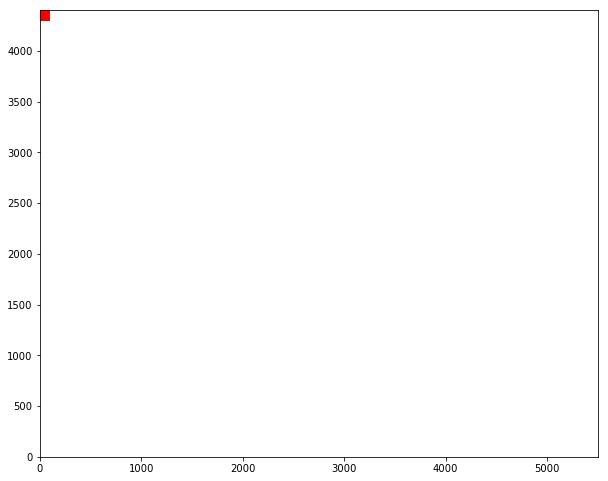

In [30]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.ModelMap(model=mf)
modelmap.plot_bc("WEL")
quadmesh = modelmap.plot_ibound()
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()